# На цей раз вам потрібно виконати завдання з цього [ноутбука]("https://colab.research.google.com/drive/1XpRovHlJJ16FZojZd8-9ci1pyiUiYogx?usp=sharing#scrollTo=Ml3jlosnF0cm"). Для вирішення запропонованих завдань вам також потрібно завантажити [датасет]("https://drive.google.com/file/d/1-4wgz9AFXrD3tZfqHJLMhCmy4BUzAX96/view?usp=sharing") з даними про оренду велосипедів.

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [226]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [227]:
URL = "https://drive.usercontent.google.com/download?id=1-4wgz9AFXrD3tZfqHJLMhCmy4BUzAX96&export=download"

df = pd.read_csv(URL, header=0) # put your code here
if len(df) == 0:
    print("Error: file not found")
    raise ValueError

df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

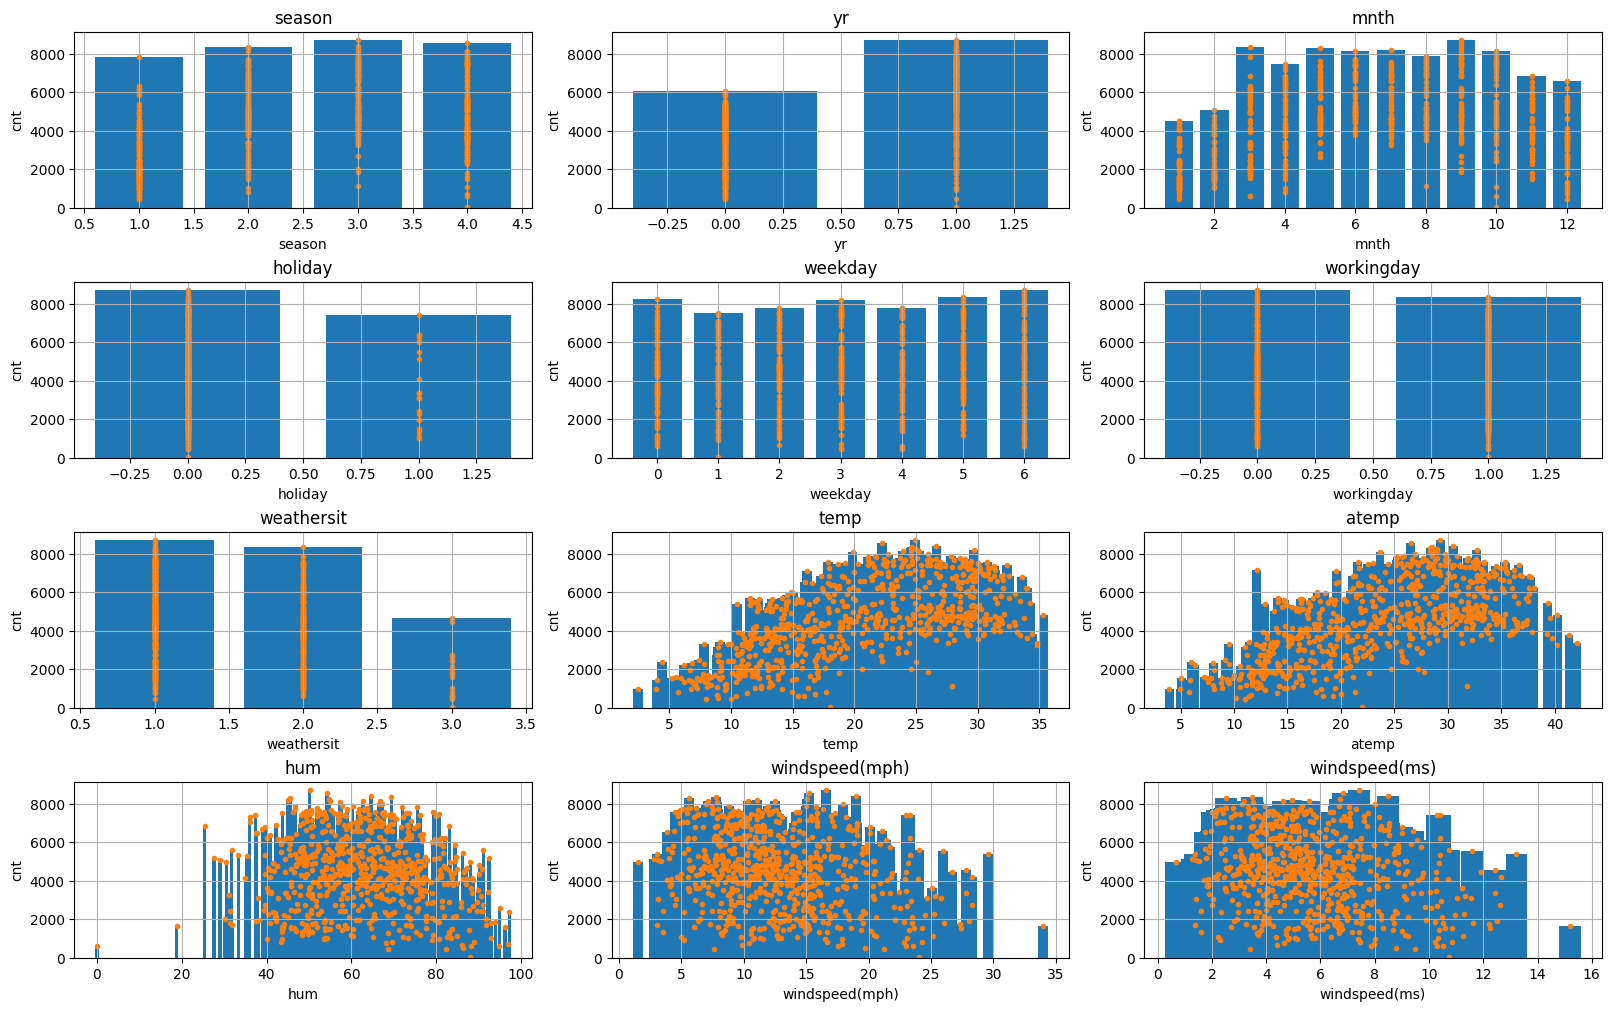

In [228]:
# Put you code here
# main_year = 2011

df_features_columns = df.columns[:-1]
df_target_column = df.columns[-1]


plot_cols = 3
plot_rows = len(df_features_columns) // plot_cols


fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(16, 10), layout="constrained")

for ax, feature in zip(axs.flatten(), df_features_columns):
    ax.bar(
        df[feature],
        df[df_target_column],
    )
    ax.scatter(
        df[feature],
        df[df_target_column],
        marker=".",
    )
    ax.set_xlabel(feature)
    ax.set_ylabel(df_target_column)
    ax.set_title(feature)
    ax.grid()

plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця? 
    $\\$ __Відповідь__: В теплі місяці прокатів більш ниж у хододні за порою року залежно від розсташуваяння прокату (судячи з результатів можно припустити що данні приведени для західноі европи)
2. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно?
    $\\$ __Відповідь__: temp(atemp), також може не так виразливо windspeed

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [229]:
# Put your code here
# df[df_features_columns].corr()
df[df_features_columns].corrwith(df[df_target_column])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


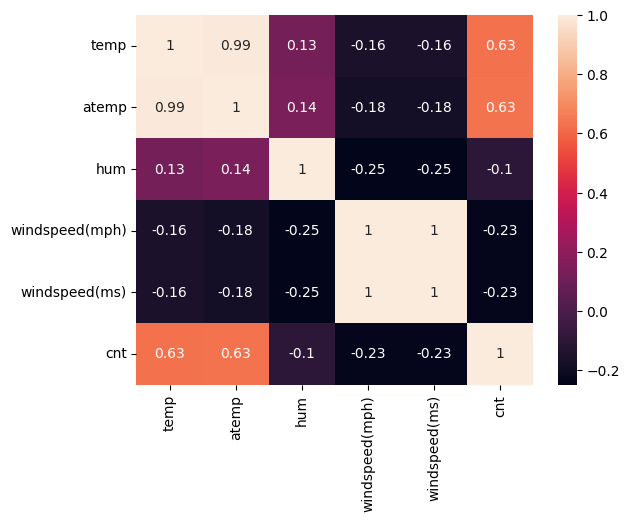

In [230]:
# Put your code here
import seaborn as sns


column_pair_correlation = ["temp", "atemp", "hum","windspeed(mph)", "windspeed(ms)"]

df_corr = df[column_pair_correlation].corrwith(df[df_target_column])
print(df_corr)

sns.heatmap(df[column_pair_correlation + [df_target_column]].corr(), annot=True)
plt.show()

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [231]:
# Put your code here
means = df.mean()
means

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

### Проблема перша: колінеарні ознаки

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [232]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [233]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

df_shuffled

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
703,4,1,12,0,2,1,1,19.509153,23.45270,73.3750,11.666643,5.215308,6606
33,1,0,2,0,4,1,1,7.665237,8.89390,43.7826,18.609384,8.318902,1550
300,4,0,10,0,5,1,2,13.564153,15.94060,58.5833,15.375093,6.873086,3747
456,2,1,4,0,0,0,2,17.459153,20.86435,67.6250,11.541889,5.159539,6041
633,4,1,9,0,2,1,1,22.550000,27.20895,57.0000,15.833507,7.078009,7538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1,0,3,0,0,0,1,15.758268,19.00455,52.7391,18.130468,8.104814,2417
106,2,0,4,0,0,0,1,18.723347,22.28480,47.9583,20.334232,9.089956,3744
270,4,0,9,0,3,1,2,26.035000,28.75790,84.8750,9.958143,4.451561,3907
435,1,1,3,0,0,0,1,14.831299,17.98350,47.6957,14.913329,6.666665,4911


Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [234]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [235]:
from IPython.display import Markdown, display

def weight_display(weight, rounding='5f'):
    columns_for_x_display = "\\\\".join(df_features_columns)
    columns_for_y_display = "\\\\".join([f"{_:.{rounding}}" for _ in weight])

    return display(
        Markdown(
            f"$$ \\vec x = \\begin{{pmatrix}} 1 \\\\ {columns_for_x_display} \\end{{pmatrix}} ,   \\vec {{\\omega}} = \\begin{{pmatrix}} {columns_for_y_display} \\end{{pmatrix}} $$"
        )
    )

In [236]:
# Put your code here
model_linenian = LinearRegression()
linenian_regressor = model_linenian.fit(X, y)

weight_linenian_regressor = np.concatenate(
    ([linenian_regressor.intercept_], linenian_regressor.coef_)
)

weight_display(weight_linenian_regressor)


$$ \vec x = \begin{pmatrix} 1 \\ season\\yr\\mnth\\holiday\\weekday\\workingday\\weathersit\\temp\\atemp\\hum\\windspeed(mph)\\windspeed(ms) \end{pmatrix} ,   \vec {\omega} = \begin{pmatrix} 4504.35453\\570.86364\\1021.96042\\-141.30063\\-86.75760\\137.22726\\56.38980\\-330.22718\\367.47990\\585.55218\\-145.61552\\12454356291009.72656\\-12454356291208.18750 \end{pmatrix} $$

Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [237]:
# Put your code here
from sklearn.linear_model import Lasso


model_lasso = Lasso()
lasso_regressor = model_lasso.fit(X, y)

weight_lasso_regressor = np.concatenate(
    ([lasso_regressor.intercept_], lasso_regressor.coef_)
)

weight_display(weight_lasso_regressor, rounding="12f")

$$ \vec x = \begin{pmatrix} 1 \\ season\\yr\\mnth\\holiday\\weekday\\workingday\\weathersit\\temp\\atemp\\hum\\windspeed(mph)\\windspeed(ms) \end{pmatrix} ,   \vec {\omega} = \begin{pmatrix} 4504.348837209302\\560.241616030886\\1019.463494065720\\-128.730627036787\\-86.152781333711\\137.347893904963\\55.212370641357\\-332.369856962349\\376.363236209694\\576.530793504555\\-144.129155003486\\-197.139689402484\\-0.000000028051 \end{pmatrix} $$

Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [238]:
# Put your code here
from sklearn.linear_model import Ridge


model_ridge = Ridge()
ridge_regressor = model_ridge.fit(X, y)

weight_ridge_regressor = np.concatenate(
    ([ridge_regressor.intercept_], ridge_regressor.coef_)
)

weight_display(weight_ridge_regressor, rounding="12f")

$$ \vec x = \begin{pmatrix} 1 \\ season\\yr\\mnth\\holiday\\weekday\\workingday\\weathersit\\temp\\atemp\\hum\\windspeed(mph)\\windspeed(ms) \end{pmatrix} ,   \vec {\omega} = \begin{pmatrix} 4504.348837209302\\563.064572252016\\1018.948378787528\\-131.873320282476\\-86.746097997092\\138.005111178719\\55.903110375064\\-332.349788499072\\386.457889191899\\566.347047060077\\-145.071327298673\\-99.259441081743\\-99.259441154389 \end{pmatrix} $$

### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [239]:
alphas = np.arange(1, 500, 50)

coefs_lasso = [] # Put your code here
coefs_ridge = [] # Put your code here

for alpha in alphas:
    # Put your code here
    lasso_regressor.set_params(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)
    
    ridge_regressor.set_params(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)

# Put your code here
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

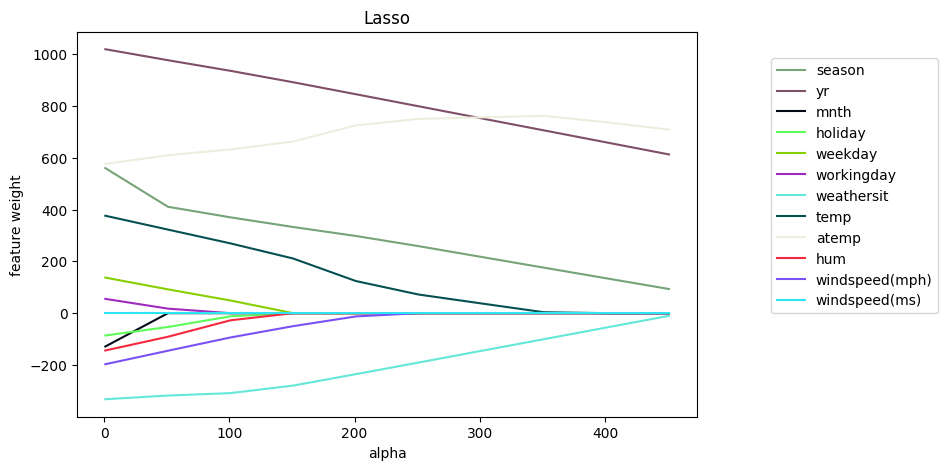

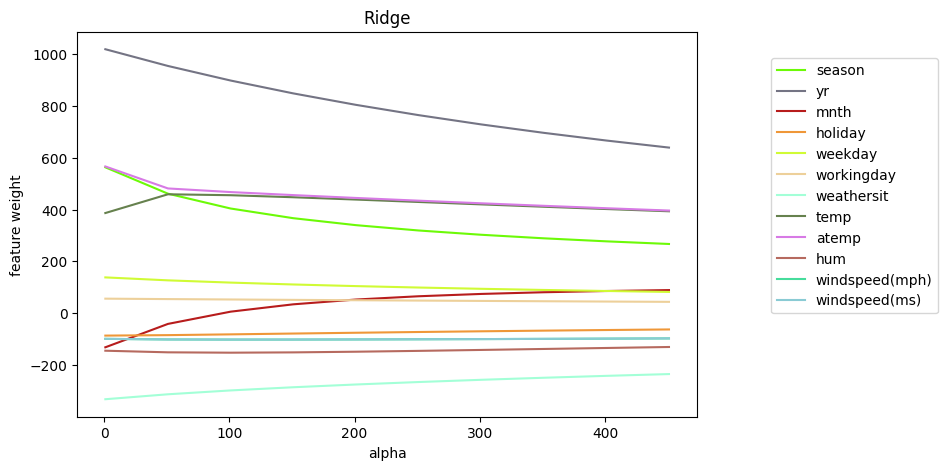

In [240]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
    $\\$ __Відповідь__: `Lasso`
2. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
    $\\$ __Відповідь__: Чим біше alpha тим більш зменшуются ваги. `Lasso` - намагається зменшувати кількість параметрів (складність моделі) зануляючи ваги
3. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
    $\\$ __Відповідь__: Так `Lasso` виключає одну з ознак. `Ridge` - залишає ваги достатьно малими, не роблячи нульовими.
4. Який із регуляризаторів підійде для відбору неінформативних ознак?
    $\\$ __Відповідь__: `Lasso` -  просто прирівняючи їх до нуля

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [241]:
def create_plot(data, title, xlabel, ylabel, figsize=None):

    size = figsize or (15, 5)
    plt.figure(figsize=size)

    # x = map(lambda e: e[0], data)
    # y = map(lambda e: e[1], data)
    x = data[0]
    y = data[1]
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()

    plt.show()

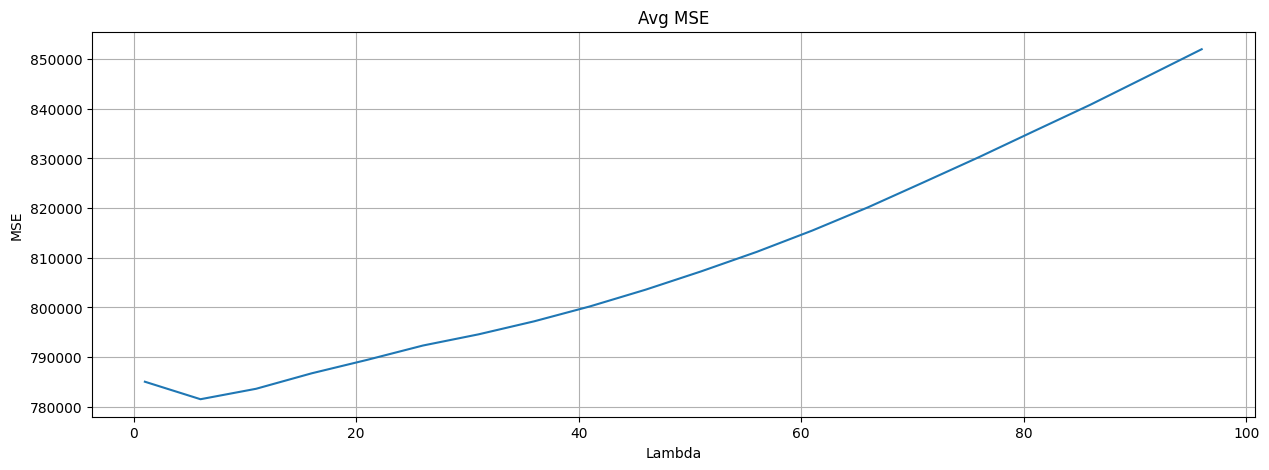

In [242]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3, random_state=42) # Put your code here
regressor.fit(X, y)

mse_values = np.mean(regressor.mse_path_, axis=1)

create_plot(
    np.vstack((regressor.alphas_, mse_values)),
    "Avg MSE",
    "Lambda",
    "MSE",
)


Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alphas with minimum MSE:
Alpha = 51, MSE = 796979.8955193633
Alpha = 6, MSE = 733725.7604052245
Alpha = 1, MSE = 799433.1673691699


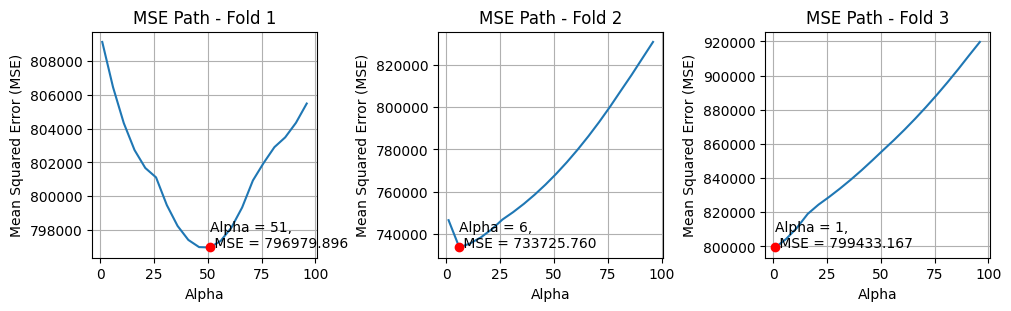

In [243]:
# Put your code here
print("Alphas with minimum MSE:")

min_mse = np.argwhere(regressor.mse_path_ == np.min(regressor.mse_path_, axis=0))

fig, axs = plt.subplots(1, min_mse.shape[0], figsize=(10, 3), layout="constrained")
for idx, i in enumerate(min_mse):
    print(f"Alpha = {regressor.alphas_[i[0]]}, MSE = {regressor.mse_path_[i[0]][i[1]]}")
    # create_plot(np.vstack((regressor.alphas_, regressor.mse_path_[:, idx])),f'MSE Path - Fold {idx + 1}', 'Alpha', 'MSE')
    axs[idx].plot(regressor.alphas_, regressor.mse_path_[:, i[1]])
    axs[idx].plot(regressor.alphas_[i[0]],
        regressor.mse_path_[i[0]][i[1]], "or")
    axs[idx].set_title(f"MSE Path - Fold {idx + 1}")
    axs[idx].set_xlabel("Alpha")
    axs[idx].set_ylabel("Mean Squared Error (MSE)")
    axs[idx].text(
        regressor.alphas_[i[0]],
        regressor.mse_path_[i[0]][i[1]],
        f"Alpha = {regressor.alphas_[i[0]]}, \n MSE = {regressor.mse_path_[i[0]][i[1]]:.3f}",
        ha="left",
    )
    axs[idx].grid()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [258]:
def normalize(data: np.array):

    mean = np.mean(data, axis=0)

    value_range = np.max(data, axis=0) - np.min(data, axis=0)

    result = []

    for value in data:
        result.append((value - mean) / value_range)

    return result

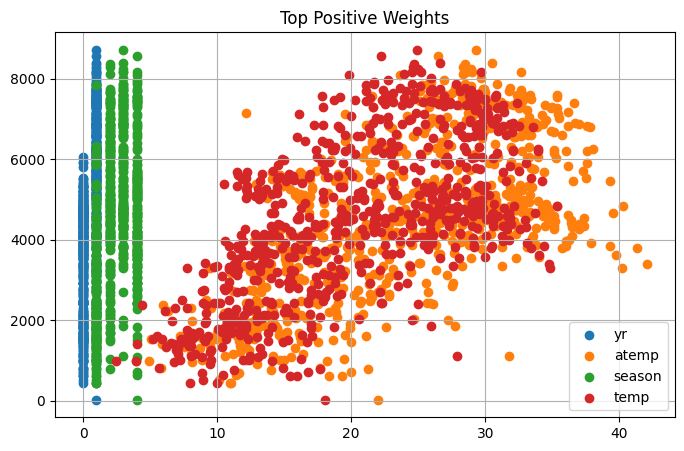

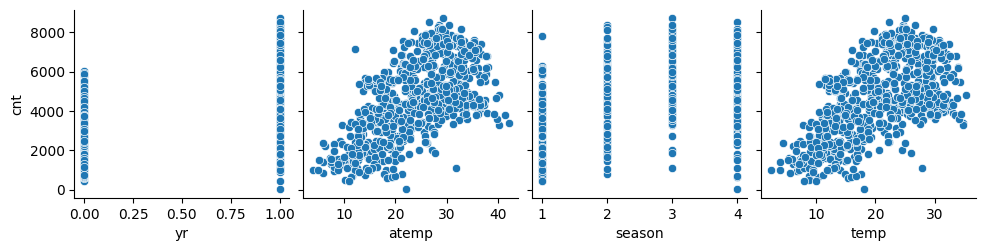

,weight
yr,1015.060223
atemp,581.396931
season,532.018983
temp,370.679855


In [303]:
# weight_regressor = np.concatenate(
#     ([regressor.intercept_], regressor.coef_)
# )
# weight_display(weight_regressor, rounding="12f")


data_weights = pd.DataFrame(
    regressor.coef_,
    df_features_columns,
    columns=["weight"],
)

top_count = 4
data_weights_top_positive = data_weights.sort_values(by="weight", ascending=False).head(
    top_count
)


plt.figure(figsize=(8, 5))
plt.title("Top Positive Weights")
for idx, i in enumerate(data_weights_top_positive.index):
    plt.scatter(df[i], df[df_target_column], label=i)
    # axs[idx].scatter(df[i], df[df_target_column],  label=i)
    # if i in ["atemp", "temp"]:
    #     sns.lineplot(y=df_target_column, x=i, ax=axs[idx], data=df[[i] + [df_target_column]])
plt.legend()
plt.grid()

sns.pairplot(
    df, x_vars=data_weights_top_positive.index.to_list(), y_vars=df_target_column
)
plt.show()

data_weights_top_positive

Про `yr` - так казати точно не можна (чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди)

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

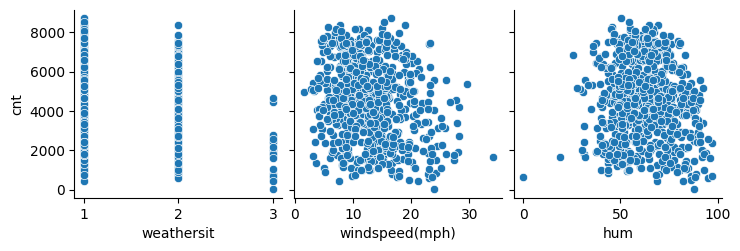

,weight
weathersit,330.559857
windspeed(mph),191.771408
hum,140.007406


In [319]:
top_count = 3

data_weights_top_negative = (
    data_weights[data_weights < 0]
    .sort_values(by="weight", ascending=True)
    .abs()
    .head(top_count)
)


sns.pairplot(
    df, x_vars=data_weights_top_negative.index.to_list(), y_vars=df_target_column
)
plt.show()

data_weights_top_negative

У ціх ознак мабуть так, чим більшою є величина цих ознак, тим менше людей захочуть узяти велосипеди.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

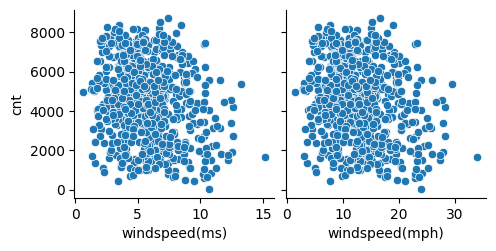

,weight
windspeed(ms),-2.685470e-08


In [320]:
data_weights_bellow_zero = (
    data_weights[data_weights.abs() < 1e-3].dropna()
    .sort_values(by="weight", ascending=True)
)

sns.pairplot(
    df, x_vars=["windspeed(ms)", "windspeed(mph)"], y_vars=df_target_column
)
plt.show()

data_weights_bellow_zero

Тому що це той самий показник в іншої одиниці виміру,  і вплив його аналогічний

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.